In [1]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#Importing libraries for data analysis and cleaning
import numpy as np
import pandas as pd

#importing visualisation libraries for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px

#load datasets
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

#per describtion, loan amount is in 1000's
train['LoanAmount'] = train['LoanAmount'] *1000
test['LoanAmount'] = test['LoanAmount'] *1000

In [2]:
temp = train.dropna()

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
temp['Loan_Status'] = encoder.fit_transform(temp['Loan_Status'])
temp['Property_Area'] = encoder.fit_transform(temp['Property_Area'])
temp['Education'] = encoder.fit_transform(temp['Education'])

In [4]:
temp['Dependents'] = encoder.fit_transform(temp['Dependents'])
temp['Married'] = encoder.fit_transform(temp['Married'])
temp['Self_Employed'] = encoder.fit_transform(temp['Self_Employed'])
temp['Gender'] = encoder.fit_transform(temp['Gender'])

**Correlations**

We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient gives us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

1. .00 -.19 “very weak”
2. .20 -.39 “weak”
3. .40 -.59 “moderate”
4. .60 -.79 “strong”
5. .80 -1.0 “very strong”

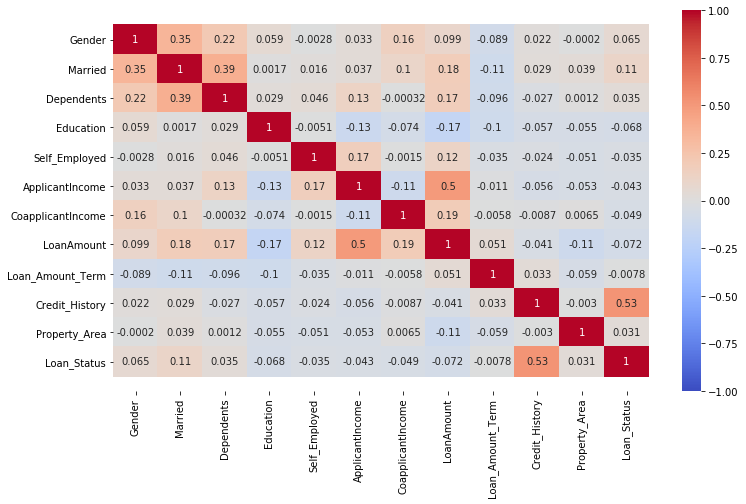

In [5]:
#Correlations in data
plt.figure(figsize=(12,7))
ax = sns.heatmap(temp.corr(),cmap='coolwarm',annot=True,vmax=1,vmin=-1);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

## Observations

1. Loan amount is skewed to the right. This is because there are a few customers applying for large loans whiles the majority are applying for loans within the median (60,000 - 200,000). This resulted in the outliers seen in the boxplot

2. Loans are mostly approved for property areas in the semiurban areas followed by urban areas where majority are graduates.

3. Credit history is a high determinant for the status of loan approval. There is a positive correlation of 0.5

4. Married couples have a slight possibility of having their loans approved

5. There is also a slight correlation with coapplicant income and the loan amount.

6. There are 7 columns in the training dataset with missing values that need to be filled. The machine learning algorthim cannot process data that has missing values.


#### Filling out missing values based on observations

In [9]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
#Save loanID
train_ID= train['Loan_ID']
train = train.drop('Loan_ID',axis=1)

In [11]:
#filling n/a with the most occuring for genders
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])

In [12]:
#filling values for married
train['Married'] = train['Married'].fillna(train['Married'].mode()[0])

In [13]:
#filling values for dependents
train['Dependents'] = train['Dependents'].fillna(train['Dependents'].mode()[0])

In [14]:
#filling values for self_employed
train['Self_Employed'] = train['Self_Employed'].fillna(train['Self_Employed'].mode()[0])

In [15]:
avg_loans = train.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
avg_loans

Education,Graduate,Not Graduate
Self_Employed,,
No,130000.0,113000.0
Yes,157500.0,130000.0


In [16]:
avg_loans.columns

Index(['Graduate', 'Not Graduate'], dtype='object', name='Education')

In [17]:
def values(x):
    return avg_loans.loc[x['Self_Employed'],x['Education']]

In [19]:
train['LoanAmount'] = train['LoanAmount'].fillna(train[train['LoanAmount'].isnull()].apply(values, axis=1))

From the observation some customers are likely to apply for larger loans and this is the reason for the loan amount being rightly skewed. Lets log the loan amount

In [20]:
#filling based on the most frequent
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0])

From the observations above, credit history is a high determinant for loan approval (correlation of +0.5) and for that reason, null values for credit history would be filled based on where loan status was approved or declined.

#### Convert Loan_Status to numerical
where Y = 1
where N = 0

In [21]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
train['Loan_Status'] = encoder.fit_transform(train['Loan_Status'])

In [22]:
train[train['Credit_History'].isnull()].head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
16,Male,No,1,Not Graduate,No,3596,0.0,100000.0,240.0,NaN,Urban,1
24,Male,Yes,1,Graduate,No,3717,2925.0,151000.0,360.0,NaN,Semiurban,0
30,Male,Yes,1,Graduate,No,4166,3369.0,201000.0,360.0,NaN,Urban,0
42,Male,Yes,0,Graduate,No,2400,0.0,75000.0,360.0,NaN,Urban,1
79,Male,Yes,3+,Not Graduate,Yes,3333,2166.0,130000.0,360.0,NaN,Semiurban,1


In [23]:
#filling credit_history where loan status was approved
train['Credit_History'] = np.where(((train['Credit_History'].isnull()) & (train['Loan_Status'] ==1)),
                                   1,train['Credit_History'])

#filling credit_history based on where loan status was declined
train['Credit_History'] = np.where(((train['Credit_History'].isnull()) & (train['Loan_Status'] ==0)),
                                   0,train['Credit_History'])

#### Creating Features

In [24]:
#Log transfromations
train['LoanAmount'] = np.log1p(train['LoanAmount'])

In [25]:
#Log transforming features
train['ApplicantIncome'] = np.log1p(train['ApplicantIncome'])
train['CoapplicantIncome'] = np.log1p(train['CoapplicantIncome'])

In [26]:
#coapplicant income and applicant income both serves as determinants for loan status
#log transformation

train['total_income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['total_income'] = np.log1p(train['total_income'])

In [27]:
#Log transformation 
train['Ratio of LoanAmt :Total_Income'] = train['LoanAmount'] / train['total_income']
train['Ratio of LoanAmt :Total_Income'] = np.log1p(train['Ratio of LoanAmt :Total_Income'])

## Categorical Variables and Dummy Variables

Machine learning algorithims cannot take in words/categorical variables. Therefore, they need to be encoded(represented) in the form of numbers before the models can handle them. A process called One-Hot encoding is used and this creates categorical variables into 0's and 1's giving a unique representation of each as and when they occur in the dataset.

A Pandas function called 'pd.get_dummies' is used in this scenario to one hot encode (represent) these categorical variables.

In [28]:
#checking the categorical variables in the dataset
train.select_dtypes(['object']).columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')

In [29]:
#One hot encoding variables
Dummies = pd.get_dummies(train[['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']],drop_first=True)

#Dropping the columns which got one hot-encoded
train = train.drop(['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'],axis=1)

#Combining the one-hot encoded variables into the actual dataset to make it as one
train = pd.concat([train,Dummies],axis=1)

In [30]:
#Viewing the combined dataset with one-hot enocoded variables
train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,total_income,Ratio of LoanAmt :Total_Income,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,8.674197,0.000000,11.775297,360.0,1.0,1,2.269462,1.822706,1,0,0,0,0,0,0,0,1
1,8.430327,7.319202,11.759793,360.0,1.0,0,2.818370,1.643366,1,1,1,0,0,0,0,0,0
2,8.006701,0.000000,11.097425,360.0,1.0,1,2.197969,1.799884,1,1,0,0,0,0,1,0,1
3,7.857094,7.765993,11.695255,360.0,1.0,1,2.810793,1.641099,1,1,0,0,0,1,0,0,1
4,8.699681,0.000000,11.856522,360.0,1.0,1,2.272093,1.827501,1,0,0,0,0,0,0,0,1


## Train/Test Split

The train dataset would be split into two. One for training and the other for testing the model to see how well it will perform against the true lables. This enables the data scientist to see the actual performance of the model on data it hasnt seen before(test data). When satisfied with the performance, the model can then be deployed for use on the actual test dataset provided for predictions.

In this scenario, the train data would be split into a 90% (for training) and the 10% for testing to measure performance.

In [31]:
#Defining the variables X and y Where; 

#X are the features for training 
X = train.drop('Loan_Status',axis=1)

#y is the target(Loan_Status) to be predicted
y = train['Loan_Status']

In [32]:
#Splitting the train data into train and test purposes.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#### Feauture scaling

This is done to normalise or standardise the features of a dataset. Since each column has data in different magnitudes or units of measurement, if the data is not scaled, the machine learning algorithm would consider some features as higher than the others. 
Example: 1000km and 6kgs are different units of different magnitudes, if these are not scaled, it could output wrong predictions.

In [33]:
#Scaling features. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Models for predictions

1. Logistic Regression

2. XGBOOST

3. Support Vector Machines Classifier

4. Random Forest Classifiers

5. Neural Networks (Simple Artificial Neural Network)


In [34]:
from sklearn.metrics import classification_report,confusion_matrix

In [35]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score

### Logistic Regression 

Prediction accuracy  88.7%

In [36]:
from sklearn.linear_model import LogisticRegression

**Default parameters**

In [37]:
model_LR = LogisticRegression()
model_LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
pred_LR = model_LR.predict(X_test)
print(classification_report(y_test,pred_LR))
print('\n')
print(confusion_matrix(y_test,pred_LR))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.88      0.98      0.93        47

    accuracy                           0.89        62
   macro avg       0.89      0.79      0.82        62
weighted avg       0.89      0.89      0.88        62



[[ 9  6]
 [ 1 46]]


In [39]:
print(accuracy_score(pred_LR,y_test))

0.8870967741935484


**Tuned hyper-parameters**

In [40]:
model_LR2 = LogisticRegression()
tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']
                   }

LR = GridSearchCV(estimator=model_LR2,
                  param_grid=tuned_parameters,
                  cv=10,
                 scoring='accuracy',n_jobs=-1)

LR.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [41]:
LR.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
pred_LR2 = LR.predict(X_test)
print(classification_report(y_test,pred_LR2))
print('\n')
print(confusion_matrix(y_test,pred_LR2))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.88      0.98      0.93        47

    accuracy                           0.89        62
   macro avg       0.89      0.79      0.82        62
weighted avg       0.89      0.89      0.88        62



[[ 9  6]
 [ 1 46]]


In [43]:
print(accuracy_score(pred_LR2,y_test))

0.8870967741935484


### Support vector machine classifier 

Prediction accuracy  88.7 %

**Default parameters**

In [45]:
from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
pred_svc = model_svc.predict(X_test)
print(classification_report(y_test,pred_svc))
print('\n')
print(confusion_matrix(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.88      0.98      0.93        47

    accuracy                           0.89        62
   macro avg       0.89      0.79      0.82        62
weighted avg       0.89      0.89      0.88        62



[[ 9  6]
 [ 1 46]]


In [47]:
print(accuracy_score(pred_svc,y_test))

0.8870967741935484


**Parameter Tuuning**

In [48]:
# Applying Grid Search to find the best model and the best parameters
model_svc2 = SVC()
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
svm = RandomizedSearchCV(estimator = model_svc2,
                         param_distributions=parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
svm.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions=[{'C': [1, 10, 100, 1000],
                                         'kernel': ['linear']},
                                        {'C': [1, 10, 100, 1000],
                                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                   0.7, 0.8, 0.9],
                                         'kernel': ['rbf']}],
                   pre_dispatch='2*n_jobs', random_state=Non

In [49]:
svm.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
pred_svc2 = svm.predict(X_test)
print(classification_report(y_test,pred_svc2))
print('\n')
print(confusion_matrix(y_test,pred_svc2))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.86      0.91      0.89        47

    accuracy                           0.82        62
   macro avg       0.76      0.72      0.74        62
weighted avg       0.81      0.82      0.82        62



[[ 8  7]
 [ 4 43]]


In [51]:
print(accuracy_score(pred_svc2,y_test))

0.8225806451612904


### Random Forest Classifier

Default parameters (Prediction accuracy  87 %)

Adjusted Parameters (Prediction accuracy 88.7%)

**Default Parameters**

In [52]:
from sklearn.ensemble import RandomForestClassifier
model_RR = RandomForestClassifier()
model_RR.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
pred_rr = model_RR.predict(X_test)
print(classification_report(y_test,pred_rr))
print('\n')
print(confusion_matrix(y_test,pred_rr))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69        15
           1       0.88      0.96      0.92        47

    accuracy                           0.87        62
   macro avg       0.85      0.78      0.81        62
weighted avg       0.87      0.87      0.86        62



[[ 9  6]
 [ 2 45]]


In [54]:
print(accuracy_score(pred_rr,y_test))

0.8709677419354839


**Tuned hyperparameters**

In [55]:
model_RR2 = RandomForestClassifier()

tuned_parameters = {'min_samples_leaf': range(2,100,10), 
                    'n_estimators' : range(100,550,50),
                    'max_features':['auto','sqrt','log2'],
                    'max_depth' : range(0,100,10)
                    }

rr = RandomizedSearchCV(estimator = model_RR2,
                        param_distributions= tuned_parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

rr.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [56]:
rr.best_params_

{'n_estimators': 150,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 70}

In [57]:
pred_rr2 = rr.predict(X_test)
print(classification_report(y_test,pred_rr2))
print('\n')
print(confusion_matrix(y_test,pred_rr2))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.88      0.98      0.93        47

    accuracy                           0.89        62
   macro avg       0.89      0.79      0.82        62
weighted avg       0.89      0.89      0.88        62



[[ 9  6]
 [ 1 46]]


In [58]:
print(accuracy_score(y_test,pred_rr2))

0.8870967741935484


## Conclusion

Seems the Logistic Regression, ANN,Random Forest,Support vector machine classifiers are all achieving an **88.7 % prediction accuracy**.

Lets settle on using the logistic regression model.

In [63]:
#Training all features and target column on train dataset for final use
X = train.drop('Loan_Status',axis=1)  #------> features
y = train['Loan_Status'] #-------> target(loan_status prediction)

In [64]:
#scaling train features
full_scaler = StandardScaler()
X = full_scaler.fit_transform(X)

In [65]:
#shape of train (features and target)
X.shape,y.shape

((614, 16), (614,))

In [66]:
LR.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

### Test Data

Preparing the actual test data for predictions.

In [67]:
#Checking first 5 rows of the test data
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110000.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126000.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208000.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100000.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78000.0,360.0,1.0,Urban


In [68]:
#Checking for null values
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [69]:
#filling null_values
test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])
test['Dependents'] = test['Dependents'].fillna(test['Dependents'].mode()[0])
test['Self_Employed'] = test['Self_Employed'].fillna(test['Self_Employed'].mode()[0])

In [70]:
#fiiling loan amt based on the defined function used on train
test['LoanAmount'] = test['LoanAmount'].fillna(test[test['LoanAmount'].isnull()].apply(values, axis=1))

In [71]:
#filling based on the most frequent
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mode()[0])

In [72]:
test['Credit_History'].value_counts()
#filling based on the most frequent
test['Credit_History'] = test['Credit_History'].fillna(test['Credit_History'].mode()[0])

In [73]:
#Log_transformations
test['ApplicantIncome'] = np.log1p(test['ApplicantIncome'])
test['CoapplicantIncome'] = np.log1p(test['CoapplicantIncome'])
test['LoanAmount'] = np.log1p(test['LoanAmount'])
test['total_income'] = test['ApplicantIncome'] + test['CoapplicantIncome']
test['total_income'] = np.log1p(test['total_income'])
test['Ratio of LoanAmt:Total_income'] = test['LoanAmount']/test['total_income']
test['Ratio of LoanAmt:Total_income'] = np.log1p(test['Ratio of LoanAmt:Total_income'])

In [74]:
test.select_dtypes(['object']).columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

In [75]:
#Save loanID
test_ID= test['Loan_ID']
test = test.drop('Loan_ID',axis=1)

In [76]:
dummies = pd.get_dummies(test[['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']],drop_first=True)
test = test.drop(['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'],axis=1)
test = pd.concat([test,dummies],axis=1)

In [77]:
#scaling test features
scaled_test = full_scaler.transform(test)

In [78]:
result = LR.predict(scaled_test)

In [79]:
#reassigning target names Y and N
result = np.where(result ==1, 'Y', 'N')
result = pd.Series(result,name='Loan_Status')

In [80]:
test_predictions = pd.concat([test_ID,result],axis=1)
test_predictions['Loan_Status'].value_counts()

Y    308
N     59
Name: Loan_Status, dtype: int64

In [81]:
test_predictions['Loan_Status'].value_counts()

Y    308
N     59
Name: Loan_Status, dtype: int64

### Final results 

In [84]:
test_predictions.set_index('Loan_ID',inplace=True)

In [85]:
test_predictions.to_csv('submission_1.csv')